### Introduction

In this notebook, we utilize the PennyLane Python library to develop a quantum Generative Adversarial Network (QGAN) intended for use with a two-qubit quantum computing system.

The QGAN's structure includes a quantum circuit for preparing data to create the training state, a variational quantum generator that aims to duplicate this state, and a quantum discriminator whose purpose is to distinguish between the generated state and the authentic state.

### Imports

In [3]:
# Notebook executed in Colab.
# ! pip install PennyLane

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn

import pennylane as qml

print(qml.__version__)
print(np.__version__)
print(torch.__version__)

0.34.0
1.23.5
2.1.0+cu121


### Quantum Generative Adversarial Network

We use the PennyLane to create a quantum Generative Adversarial Network (QGAN) designed to operate on a two-qubit quantum computing device.

The architecture of the QGAN consists of a data-preparing quantum circuit for generating the training state, a variational quantum generator to replicate this state,
and a quantum discriminator tasked with differentiating between the generated and true states.

In [5]:
phi = np.pi / 3
theta = np.pi / 4
delta = np.pi / 5

In [6]:
def PrepareTrueState():
    qml.U3(theta, phi, delta, wires = 0)

In [7]:
def GeneratorVF(weights):
    qml.U3(weights[0], weights[1], weights[2], wires = 0)

In [8]:
def DiscriminatorVF(nqubits, weights, reps = 1):
    par = 0 # Index for parameters.
    for rep in range(reps):
        for q in range(nqubits):
            qml.RX(weights[par], wires = q)
            par += 1
            qml.RY(weights[par], wires = q)
            par += 1
            qml.RZ(weights[par], wires = q)
            par += 1
        for i in range(nqubits - 1):
            qml.CNOT(wires = [i, i + 1])

    for q in range(nqubits):
        qml.RX(weights[par], wires = q)
        par += 1
        qml.RY(weights[par], wires = q)
        par += 1
        qml.RZ(weights[par], wires = q)
        par += 1

In [9]:
def Generator(weights):
    GeneratorVF(weights)

def Discriminator(weights):
    DiscriminatorVF(2, weights, reps = 3)

In [10]:
state_0 = [[1], [0]]
M = state_0 * np.conj(state_0).T

In [11]:
dev = qml.device('default.qubit', wires = 2)

In [12]:
@qml.qnode(dev, interface="torch", diff_method = "backprop")
def true_discriminator(weights_dis):
    PrepareTrueState()
    Discriminator(weights_dis)
    return qml.expval(qml.Hermitian(M, wires = [0]))

In [13]:
@qml.qnode(dev, interface="torch", diff_method = "backprop")
def generator_discriminator(weights_gen, weights_dis):
    Generator(weights_gen)
    Discriminator(weights_dis)
    return qml.expval(qml.Hermitian(M, wires = [0]))

In [14]:
def discriminator_loss(weights_gen, weights_dis):

    # Outcome of the discriminator with a generated state.
    out_gen = generator_discriminator(weights_gen, weights_dis)

    # Outcome of the discriminator with the true state.
    out_true = true_discriminator(weights_dis)

    return -(torch.log(1 - out_gen) + torch.log(out_true))/2

In [15]:
def generator_loss(weights_gen, weights_dis):
    out_gen = generator_discriminator(weights_gen, weights_dis)
    return -torch.log(out_gen)

In [16]:
weights_gen = torch.rand(3, requires_grad = True)
weights_dis = torch.rand((3 + 1) * 2 * 3, requires_grad = True)

In [17]:
optg = torch.optim.SGD([weights_gen], lr = 0.5)
optd = torch.optim.SGD([weights_dis], lr = 0.5)

In [18]:
dis_losses = [] # Discriminator losses.
gen_losses = [] # Generator losses.
log_weights = [] # Generator weights.

In [19]:
ncycles = 150 # Number of training cycles.

In [20]:
for i in range(ncycles):
    # Train the discriminator.
    optd.zero_grad()
    lossd = discriminator_loss(weights_gen.detach(), weights_dis)
    lossd.backward()
    optd.step()

    # Train the generator.
    optg.zero_grad()
    lossg = generator_loss(weights_gen, weights_dis.detach())
    lossg.backward()
    optg.step()

    # Log losses and weights.
    lossd = float(lossd)
    lossg = float(lossg)
    dis_losses.append(lossd)
    gen_losses.append(lossg)
    log_weights.append(weights_gen.detach().clone().numpy())

    # Print the losses every fifteen cycles.
    if (np.mod((i+1), 15) == 0):
        print("Epoch", i+1, end= " ")
        print("| Discriminator loss:", round(lossd, 4), end = " ")
        print("| Generator loss:", round(lossg, 4))

Epoch 15 | Discriminator loss: 0.6824 | Generator loss: 0.73
Epoch 30 | Discriminator loss: 0.6946 | Generator loss: 0.6892
Epoch 45 | Discriminator loss: 0.6954 | Generator loss: 0.688
Epoch 60 | Discriminator loss: 0.6929 | Generator loss: 0.6944
Epoch 75 | Discriminator loss: 0.6932 | Generator loss: 0.6945
Epoch 90 | Discriminator loss: 0.6932 | Generator loss: 0.6934
Epoch 105 | Discriminator loss: 0.6931 | Generator loss: 0.693
Epoch 120 | Discriminator loss: 0.6931 | Generator loss: 0.6931
Epoch 135 | Discriminator loss: 0.6931 | Generator loss: 0.6931
Epoch 150 | Discriminator loss: 0.6931 | Generator loss: 0.6932


In [21]:
epochs = np.array(range(len(gen_losses))) + 1

<ipython-input-33-0c9380a16751>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')
<ipython-input-33-0c9380a16751>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


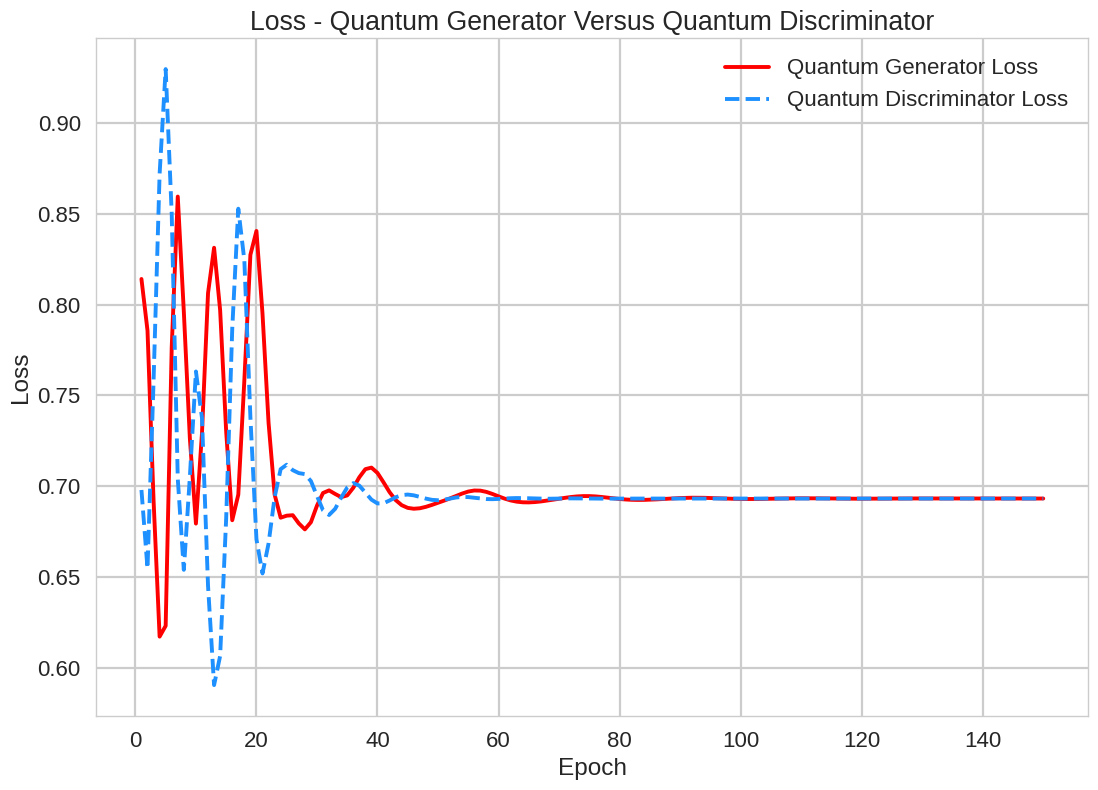

In [33]:
plt.figure()

plt.style.use('default')
plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-poster')

plt.plot(epochs, gen_losses, label = "Quantum Generator Loss", color='red')
plt.plot(epochs, dis_losses, label = "Quantum Discriminator Loss", color='dodgerblue', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss - Quantum Generator Versus Quantum Discriminator")
plt.legend();

In [23]:
@qml.qnode(dev, interface="torch")
def generated_coordinates(weights_gen):
    Generator(weights_gen)
    return [qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)),
    qml.expval(qml.PauliZ(0))]

In [24]:
@qml.qnode(dev, interface="torch")
def true_coordinates():
    PrepareTrueState()
    return [qml.expval(qml.PauliX(0)),
            qml.expval(qml.PauliY(0)),
            qml.expval(qml.PauliZ(0))]

In [25]:
print("Bloch coordinates")
print("Generated:", generated_coordinates(weights_gen))
print("True:", true_coordinates())

Bloch coordinates
Generated: [tensor(0.3536, dtype=torch.float64, grad_fn=<DotBackward0>), tensor(0.6124, dtype=torch.float64, grad_fn=<DotBackward0>), tensor(0.7071, dtype=torch.float64, grad_fn=<DotBackward0>)]
True: [tensor(0.3536, dtype=torch.float64), tensor(0.6124, dtype=torch.float64), tensor(0.7071, dtype=torch.float64)]


In [26]:
true_coords = true_coordinates()

In [27]:
true_coords

[tensor(0.3536, dtype=torch.float64),
 tensor(0.6124, dtype=torch.float64),
 tensor(0.7071, dtype=torch.float64)]

In [28]:
true_coords = true_coordinates()

In [29]:
def plot_coordinates(cycle):

    coords = generated_coordinates(log_weights[cycle - 1])

    plt.bar(["X", "Y", "Z"], true_coords, width = 1,
        color = "royalblue", label = "True coordinates")
    plt.bar(["X", "Y", "Z"], coords, width = 0.5,
        color = "black", label = "Generated coordinates")

    plt.title(f"Training cycle {cycle}")
    plt.legend()

### Conclusion

In this Jupyter Notebook we have implemented a Quantum Generative Adversarial Network (QGAN) utilizing the PennyLane Python library and PyTorch, tailored for a two-qubit quantum computing framework. The QGAN architecture comprises a data-preparing quantum circuit to generate the training state, alongside a variational quantum generator aimed at replicating this state. Additionally, a quantum discriminator was developed to effectively distinguish between the generated states and the true states. This is a simple demonstration that highlights the potential of quantum computational strategies in the domain of generative adversarial networks and also builds a foundational for exploring more complex quantum machine learning models in future notebooks.




